### Example notebook for WorkStation - differential gene expression for different cancer types

This notebook demonstrates reading from API and performing analysis of differential gene expression.
- title: "DGE - Cancer Types"
- author: "Margaret Paiva"
- date: "21/10/2021"
- output: R notebook

In [17]:
# Check your R version if packages are not compatible
R.version

In [4]:
# Install BiocManager
if (!requireNamespace("BiocManager", quietly = TRUE))
    install.packages("BiocManager")

In [3]:
# Install packages using BiocManager
for (pkg in c("limma", "fgsea")) {
    if (!requireNamespace(pkg, quietly = TRUE)) {
        BiocManager::install(pkg, update = FALSE, 
                             ask = FALSE, force = TRUE)
    }
}

In [2]:
suppressPackageStartupMessages(library(jsonlite))
suppressPackageStartupMessages(library(rjson))
suppressPackageStartupMessages(library(httr))
suppressPackageStartupMessages(library(dplyr))
suppressPackageStartupMessages(library(data.table))
suppressPackageStartupMessages(library(parallel))
suppressPackageStartupMessages(library(DBI))
suppressPackageStartupMessages(library(DT))
suppressPackageStartupMessages(library(limma))
suppressPackageStartupMessages(library(fgsea))
suppressPackageStartupMessages(library(tidyr))
suppressPackageStartupMessages(library(tibble))
suppressPackageStartupMessages(library(ggplot2))

Request data from API if it is not done yet.

In [33]:
# In "gene_list.csv", define a list of genes of interest
gene_list  <- as.list(read.csv("gene_list.csv")$x)
gene_list[1:2]

[[1]]
[1] AGR2
400 Levels: A1BG A4GALT ABCA3 ABCC3 ABCG1 ABLIM2 ABLIM3 ACE ACKR3 ACOX2 ... FOXC1

[[2]]
[1] CEACAM6
400 Levels: A1BG A4GALT ABCA3 ABCC3 ABCG1 ABLIM2 ABLIM3 ACE ACKR3 ACOX2 ... FOXC1

In [34]:
# Define the data to query from API
data  <- list("request_data_type" = "expression",
  "request_cancer_type" = c("Renal cell carcinoma", "Prostate", "Adenoid cystic carcinoma", "Breast", 
                            "Thyroid", "Testicular", "Hepatocellular carcinoma", "Melanoma"),
#   "request_genes" = c("ATM", "BRCA1", "BRCA2", "BRIP1", "CDK12", "FANCA", "HDAC2", "KRAS", 
#                       "PALB2", "SRY", "TP53", "NOTCH1", "CCND1", "BARD1", "FBLN2", "CDKN1B", 
#                       "RB1", "CHEK2", "APOBEC3B", "PALB2"),  # to define a list of genes here
  "request_genes" = gene_list,  # if a list of genes is defined in a file
  "request_dataset" = "PDX",
  "request_key" = "a3208f8f73654023bd0f267eb9d014bb",
  "request_client" = 99,
  "request_user" = 99,
  "request_mode" = 'true') 

In [35]:
# Request data from API - this may take some time
request  <-  POST(url = 'https://lumin-fast-api.championsoncology.com/workstation', 
                  body = data, encode = 'json')
request
# A successful request will give "Status: 200"

Response [https://lumin-fast-api.championsoncology.com/workstation]
  Date: 2021-10-19 20:52
  Status: 200
  Content-Type: application/json
  Size: 75 B


In [36]:
# This will save the data file as a .json file in your root directory
response <- content(request)
response

[1] "success, the file you may view your requested data in your root directory"

In [3]:
# Enter the file name of the .json file in your root directory below
lt  <-  fromJSON(file = "./data/requested_data---19-10-2021---20_44_20.json")

In [20]:
# Create a dataframe from the data
df  <- do.call(rbind, lapply(lt, rbind))
df  <- as.data.frame(df)
df$tumor_type  <- as.character(df$tumor_type)  # each column is a list - specify data type
df$z  <- as.numeric(df$z)
head(df, 2)
print(dim(df))

v1,gene_id,log.rsem.rpkm,log.tpm,z,fold,trans,model,sort_key,gene,model_name,tumor_type
19463231,ENSG00000005187,2.03154538924124,2.74114899170484,-0.1693172,0.876569685689051,ENST00000440284:49.26% ENST00000567387:17.78% ENST00000501740:11.52% ENST00000289416:10.09%,CTG-3501,CTG-3501_Expression_1,ACSM3,CTG-3501,Breast
19463234,ENSG00000005243,0.43494348437293,0.799599647207579,-0.9946150,0.185174375597962,ENST00000006101:78.76% ENST00000579263:20.8%,CTG-3501,CTG-3501_Expression_1,COPZ2,CTG-3501,Breast


[1] 82800    12


In [49]:
# Define a gene of interest
gene_choice <- 'ACSM3'
df_gene  <- df %>% 
    na.omit()  %>% 
    filter(gene==gene_choice)  # put your gene of interest here

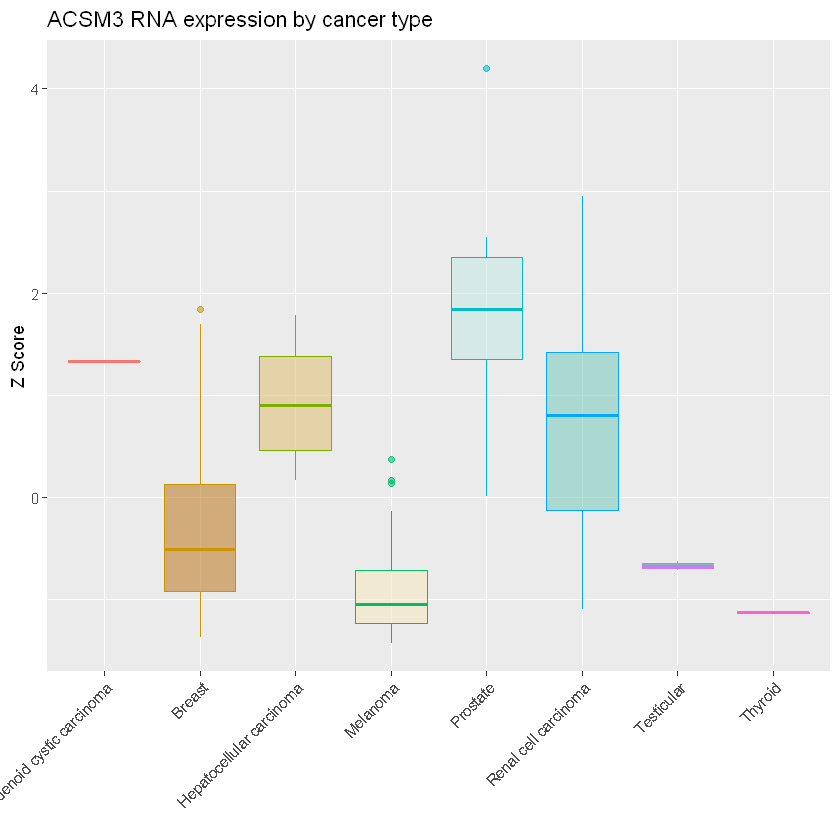

In [54]:
# Visualize the expression levels by cancer type
ggplot(df_gene, aes(x=tumor_type, y=z, fill=tumor_type, color=tumor_type)) +
    geom_boxplot(alpha=0.6) +
    theme(axis.text.x = element_text(angle = 45, hjust = 1),
         legend.position = "none") +
    labs(x="", y="Z Score", 
         title=paste0(gene_choice, " RNA expression by cancer type")) +
    scale_fill_brewer(palette="BrBG")